In [25]:
#Importing libraries
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model

In [26]:
# !pip install pydot
# !pip install plot-model

# Standard Classification vs One Shot Learning

## Standard Classification

The input image is fed through a number of layers in the case of standard classification, and at the output, it produces a probability distribution over all the classes (typically using a Softmax). 
Each input image constructs n probabilities, each representing the likelihood that the image belongs to one of the 10 classes—for instance, apple, banana, orange, or blueberry. 
Here, two crucial things need to be noted. 
First, for each class/fruit, we need a lot of photographs during the training process.
Second, we cannot expect to test the network on any other class, for instance "avocado" if it has only been trained on the 10 classes of photos not including. We must first gather a large number of avocado photographs before retraining the model if we want it to classify zebra avocado as well. In our application, automotiva part, we don't have enough data for every class, and there are a lot of classes that are constantly changing. Data gathering and regular retraining are therefore prohibitively expensive. A one-shot classification, on the other hand, can have even one training example for each class. That's why it is calles one-shot

## One shot classification

In [27]:
import glob
import os

def listdir_nohidden(path):
    """The following function get items i the folder
    add them to the relative path,"""
    return glob.glob(os.path.join(path, '*'))

We compute the similarity scores between photographs of various classes rather than utilizing enormous amounts of data for each class. Two photos, either from the same class or another, will constitute the input to this network. The result will be a number4 between 0 and 1, with 1 signifying that the two photos belong to the same class and 0 signifying that they do not.

In [28]:
base_dir = r'/Users/vazgen/Desktop/capstone/Dev/datasets/fruit/fruits-360/360/Training'
train_test_split = 0.8 ##80 percent of the data will be in training split
no_of_files_in_each_class = 10

#Read all the folders in the directory
folder_list = listdir_nohidden(base_dir)
print( len(folder_list), "fruits found in the dataset")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

#Using just 10 images per category
for folder_name in folder_list:
    files_list = listdir_nohidden(os.path.join(base_dir, folder_name))
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
label_names = [i.split('/')[-1].replace(" ","_") for i in folder_list]
print('X, Y shape',x.shape, y.shape, cat_list.shape) 

131 fruits found in the dataset
X, Y shape (1310, 100, 100, 3) (1310,) (131, 10)


In [30]:
dct_for_mapping = {}
for i,j in zip(cat_list,label_names):
    for pic in i:
        dct_for_mapping[pic]=j

- Line 1: Including the base directory of the dataset
- Line 2: Indicate the percentage that is going to be used for training. The rest will be used for testing
- Line 3: Since Fruits 360 is a dataset for Image classification, It has a lot of images per category. But for our experiment, a small portion is enough.
- Line 6: Get the list of directories from the folder. Each folder contains of particular image
- Line 10–13: Declare three empty lists to record X(images), y(labels), cat_list(To record the category of each image)
- Line 16–24: Iterate over the class folders and select ten images from each of the class, convert them to RGB format and append them to a list. keep a record of the class of the image in cat_list[] for further reference
- Line 26–28: Convert all the list to NumPy arrays. As any image will range from 0–255, divide the array x by 255 - for simplification

In [31]:
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X&Y shape of testing data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)


104 classes for training and 27  classes for testing
X&Y shape of training data : (1040, 100, 100, 3) and (1040,) (104, 10)
X&Y shape of testing data : (270, 100, 100, 3) and (270,) (27, 10)


- Line 1: Calculate the number of classes that will be used for training by multiplying with the train_test_split
- Line 2: Subtract train_size from the total classes available to get the test_size
- Line 4: Multiply train_size with the number of files in each class to get the total number of training files
- Line 7–15: Use the value calculated before to subset X, Y and cat_list

# Generating Batch

In this section we generate batches for training. An X and Y should be present in the batch files. If the batch size is 64 and the picture size is (100, 100, 3), then the size of X would be a list of size 64 and each element in the list would be of size (100, 100, 3).

Given that we had two inputs, there would be a list (let's call it "A") of size 64 and each element would have a list (let's call it "B") of length 2 and a size of 64 in "A." (100, 100, 3). We'll create a batch for training so that for half the input pairings, B[0] and B[1]

In [32]:
def get_batch(batch_size=64):
    """Generating batches"""
    temp_x = x_train
    temp_cat_list = cat_train
    start=0
    end=train_size
    batch_x=[]
        
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(start, end, batch_size) 
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]  
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            
    return(batch_x, batch_y)

- Line 3–7: Store the values of x_train, cat_train and the start and end size of training size in a temporary variables
- Line 9–11: Assigning half of the batch_size of Y as 0 and others as 1
- Line 13: Generate a random list of classes from the training category list to be used. Also, append two arrays of image_size*batch_size
- Line 17–25: For each iteration, In case of batch_x[0] select an image from the category specified in the class list. For batch_x[1] select an image from the same category if y[i] is 0, else select batch_x[1] from any other category except for the same one

# Architecture

A CNN model consists of a number of convolutional and pooling layers, several dense layers, and an output layer that most often has a softmax function. Here, the softmax layer is in charge of supplying a range of probabilities for each class while the convolutional layers are in charge of extracting features from the picture. The class of the image with the highest probability value is then selected.For activation functions we use sigmoid

$Softmax: \sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K $<br>
$Sigmoid: \sigma(z) = \frac{1} {1 + e^{-z}} $

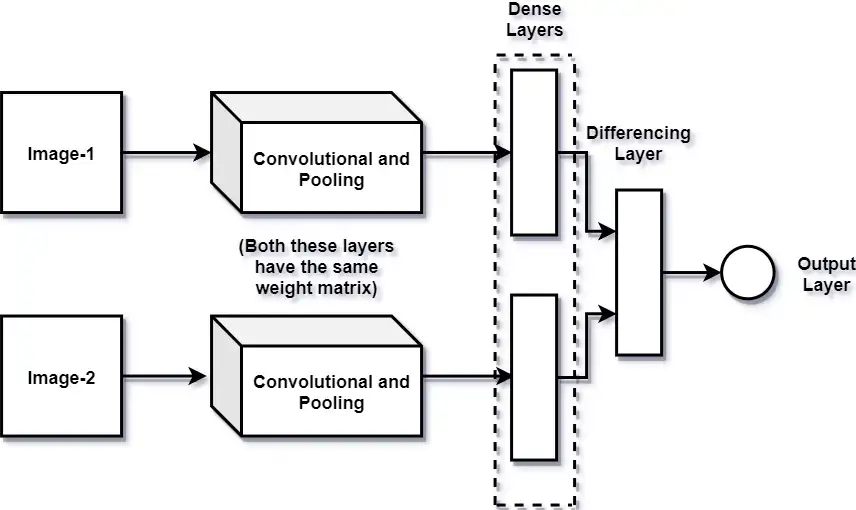

In [33]:
from IPython.display import Image
Image("fig1.png")

/Users/vazgen/miniforge3/envs/DLP/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


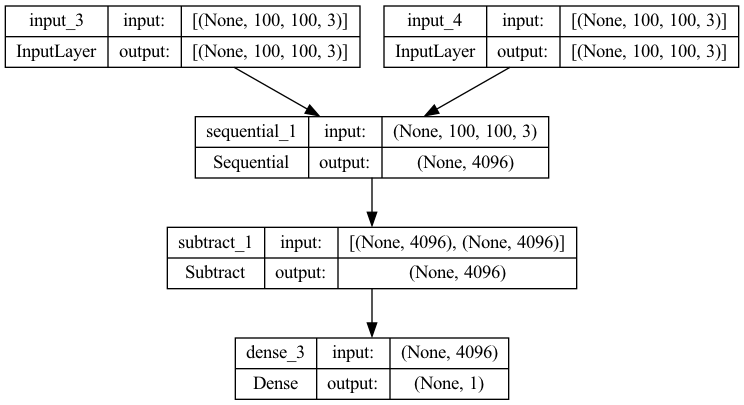

In [34]:
##see the comments below
#Building a sequential model
input_shape=(100, 100, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)
W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (7,7), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(256, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init)
])

encoded_l = model(left_input)
encoded_r = model(right_input)

subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

optimizer= Adam(learning_rate=0.0001)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

plot_model(siamese_net, show_shapes=True, show_layer_names=True)

- Line 1: Declare the shape of the input image.
- Line 2: Declare two inputs with the shape of the image.
- Line 6–7: Declare parameters for initializing weight and bias of the network. The values are chosen as described in the paper.
- Line 9–20: Declare a Sequential model with 4 convolutional layers and max-pooling layers. Use a flattening layer at last followed by a dense layer.
- Line 22–23: Pass both the inputs to the same model.
- Line 25–27: Subtract the dense layers from both the images and pass it through a single neuron with a sigmoid activation function.
- Line 29–30: Compile the model with loss as ‘binary_cross_entropy’ and ‘Adam’ optimizer.
- Line 32: The plot model function for siamese_net outputs the following.

# N-way one-shot Learning

We choose 'n' input pairs such that only one input pair belongs to the same category and the others are all from distinct ones. This is a procedure of confirming one-shot learning. 
In the case of a nine-way one-shot validation where each input to the network requires two photos, x[0] is constant across all nine pairings, x[1] only falls under the same category as x[0] across one out of every nine pairs, and x[1] is different across the other eight. 
If all nine pairs are provided to the model, it is anticipated that the pair that falls under the same category would have the pair's lowest value. 
We consider it a successful forecast in this scenario.
The number of steps in validation is indicated by the input parameter n val. 
The number of ways for each stage of validation is indicated by the term "n way." 
Keep in mind that x[0] remains constant during all validation steps.


In [35]:
def nway_one_shot(model, n_way, n_val):
    """Perform n_way classification"""
    temp_x = x_val 
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(train_size+1, len(folder_list)-1, n_val)##5-hat category random

    for i in class_list:  
        j = np.random.choice(cat_list[i])#j is a picture
        print(j.shape)
        
        temp=[]
        temp.append(np.zeros((n_way, 100, 100, 3)))
        temp.append(np.zeros((n_way, 100, 100, 3)))
        #2hat oakan vector
        for k in range(0, n_way):
            temp[0][k] = x[j]
            
            if k==0:
#                 print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
#                 print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy

- Line 3–7: Store x_val, cat_test in a temporary variable
- Line 9: This is the same as Line 13 in the batch generation, except we create a batch of random categories from the test set
- Line 11–24: For each validation step, we iterate through the n_way, take the corresponding category list from class_list, pick an image from that category and store it in x[0]. For x[1] select an image from the same category if it is the first iteration, and select from a different category for others. This inner loop is almost the same as batch_generation() method discussed above.
- Line 26–31: For each of the validation step, predict the output using the model and check if result[0] has the minimum value compared to others. Note that the result array will be a list of size n_way. If yes add 1 to n_correct. Repeat the same for all other validation steps.
- Line 32: Calculate the accuracy using n_correct and the number of validation steps.

In [36]:
#seeing available GPUs
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [37]:
tf.debugging.set_log_device_placement(True)

# Training a model

In [38]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [39]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [40]:
with tf.device('/GPU'):
    epochs = 300
    n_way = 10
    n_val = 100
    batch_size = 128
    
    loss_list=[]
    accuracy_list=[]
    for epoch in range(1,epochs):
        batch_x, batch_y = get_batch(batch_size)
        loss = siamese_net.train_on_batch(batch_x, batch_y)
        loss_list.append((epoch,loss))
        if epoch%250 == 0:
            print("=============================================")
            accuracy = nway_one_shot(siamese_net, n_way, n_val)
            accuracy_list.append((epoch, accuracy))
            print('Epoch:', epoch, ', Loss:',loss)
            print('Accuracy as of', epoch, 'epochs:', accuracy)
            print("=============================================")
            if(accuracy>99):
                print("Achieved more than 90% Accuracy")

2022-12-10 21:56:46.270550: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-10 21:56:46.270886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


()
1/1 [==============================] - 0s 107ms/step
()
1/1 [==============================] - 0s 14ms/step
()
1/1 [==============================] - 0s 14ms/step
()
1/1 [==============================] - 0s 13ms/step


2022-12-10 21:58:30.216131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


()
1/1 [==============================] - 0s 13ms/step
()
1/1 [==============================] - 0s 13ms/step
()
1/1 [==============================] - 0s 13ms/step
()
1/1 [==============================] - 0s 13ms/step
()
1/1 [==============================] - 0s 12ms/step
()
1/1 [==============================] - 0s 12ms/step
()
1/1 [==============================] - 0s 12ms/step
()
1/1 [==============================] - 0s 13ms/step
()
1/1 [==============================] - 0s 13ms/step
()
1/1 [==============================] - 0s 13ms/step
()
1/1 [==============================] - 0s 13ms/step
()
1/1 [==============================] - 0s 13ms/step
()
1/1 [==============================] - 0s 12ms/step
()
1/1 [==============================] - 0s 13ms/step
()
1/1 [==============================] - 0s 17ms/step
()
1/1 [==============================] - 0s 15ms/step
()
1/1 [==============================] - 0s 28ms/step
()
1/1 [==============================] - 0s 15ms/step
()
1/1 [==

In [41]:


!pip install --user pipenv

ERROR: unknown command "install --upgrade"
ERROR: unknown command "install --user" - maybe you meant "install"


In [42]:
!pip install --upgrade setuptools wheel

ERROR: unknown command "install --upgrade"
